# Import Libraries

In [1]:
import tensorflow as tf

import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt

tf.__version__

'2.10.1'

# Create Data

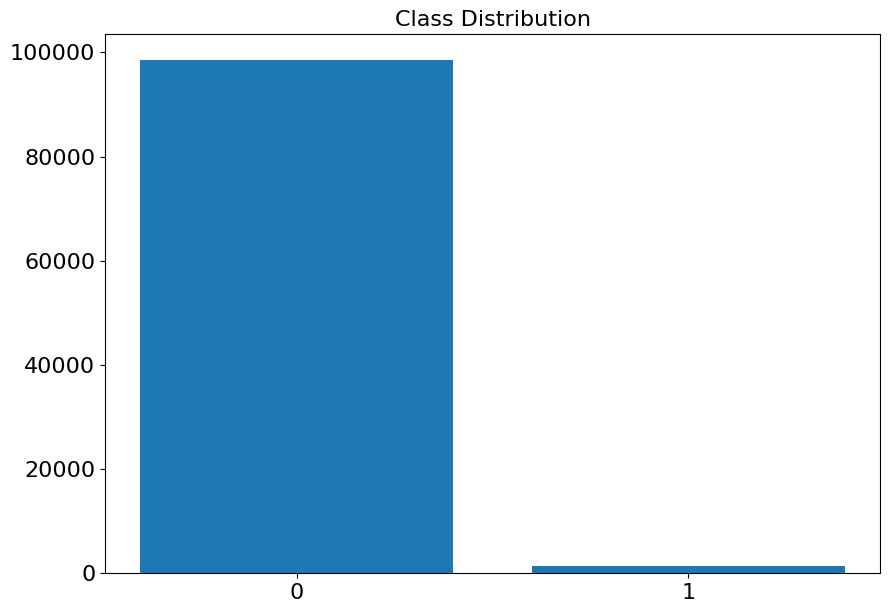

In [2]:
X, y = make_classification(n_samples = 100000,
                           n_features= 10,
                           n_classes= 2,
                           weights= [0.99, 0.01],
                           n_redundant = 0)

unique, counts = np.unique(y, return_counts=True)

plt.figure(figsize=(10,7))
plt.bar(unique, counts)

plt.xticks(unique, fontsize = 16)
plt.yticks(fontsize = 16)
plt.title("Class Distribution", fontsize = 16)

plt.show()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size= 0.2 , stratify= y , random_state= 53)

In [4]:
class_weights = compute_class_weight(class_weight= 'balanced',
                                     classes = [0, 1], # classes = np.unique(y_train)
                                     y = y_train)

class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5073438015271048, 1: 34.542314335060446}

# Models

In [5]:
input_layer = tf.keras.Input(shape=(X.shape[1],))

x = tf.keras.layers.Dense(64)(input_layer)
x = tf.nn.relu(x)

x = tf.keras.layers.Dense(32)(x)
x = tf.nn.relu(x)

x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(1)(x)
x = tf.keras.layers.Activation("sigmoid")(x)


base_model = tf.keras.models.Model(input_layer, x)
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 64)                704       
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 tf.nn.relu_1 (TFOpLambda)   (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33    

In [6]:
# base_model(np.expand_dims(X_train[0] ,axis = 0)) # You can call this way.

In [7]:
base_model.get_weights()

[array([[ 2.16108054e-01,  2.71043032e-01,  1.08210772e-01,
          1.31857395e-02, -1.68552458e-01,  1.36771411e-01,
          1.30642802e-01,  1.28387392e-01, -2.66527325e-01,
         -2.47259185e-01,  9.61025357e-02,  8.71491432e-03,
          2.46217877e-01, -3.02383304e-02, -2.15522677e-01,
          8.35797191e-03,  2.06997097e-01,  5.66520095e-02,
         -1.00547850e-01, -2.71732301e-01, -1.50074482e-01,
         -1.47621989e-01, -2.42859289e-01, -1.03544265e-01,
         -3.74167860e-02,  1.91409022e-01, -2.49071479e-01,
          2.08416730e-01,  1.35455877e-01,  2.30627745e-01,
         -1.22295633e-01, -2.17682838e-01,  5.60192168e-02,
          2.08862484e-01, -1.19528949e-01,  2.26035923e-01,
         -1.52933300e-01,  1.16830170e-02, -2.42573619e-02,
         -2.27973118e-01, -1.18794441e-02,  1.78072214e-01,
         -2.74302244e-01,  1.55341446e-01,  2.49310225e-01,
          1.87181771e-01,  2.16650456e-01, -1.55258775e-02,
         -1.61515027e-01,  2.99145579e-0

In [8]:
base_model.save_weights("initial_weights.h5")

In [9]:
class_weight_model = tf.keras.models.clone_model(base_model)
focal_loss_model = tf.keras.models.clone_model(base_model)
cat_focal_loss_model = tf.keras.models.clone_model(base_model)

In [10]:
base_model.compile(optimizer = 'adam',
                   loss = 'binary_crossentropy',
                   metrics = [tf.keras.metrics.Precision(),
                              tf.keras.metrics.Recall()])

In [11]:
history = base_model.fit(X_train, y_train, epochs = 32, batch_size=128, validation_split=0.2)

Epoch 1/32
500/500 [==============================] - 2s 2ms/step - loss: 0.1072 - precision: 0.0122 - recall: 0.0118 - val_loss: 0.0608 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/32
500/500 [==============================] - 1s 2ms/step - loss: 0.0657 - precision: 0.3333 - recall: 0.0224 - val_loss: 0.0582 - val_precision: 0.5000 - val_recall: 0.0405
Epoch 3/32
500/500 [==============================] - 1s 2ms/step - loss: 0.0635 - precision: 0.4174 - recall: 0.0513 - val_loss: 0.0573 - val_precision: 0.5000 - val_recall: 0.0541
Epoch 4/32
500/500 [==============================] - 1s 2ms/step - loss: 0.0620 - precision: 0.4336 - recall: 0.0524 - val_loss: 0.0558 - val_precision: 0.4884 - val_recall: 0.0946
Epoch 5/32
500/500 [==============================] - 1s 2ms/step - loss: 0.0610 - precision: 0.5197 - recall: 0.0705 - val_loss: 0.0558 - val_precision: 0.5806 - val_recall: 0.0811
Epoch 6/32
500/500 [==============================] - 1s 2ms/step - loss: 0.0605 -

In [12]:
base_model.evaluate(X_test, y_test)

625/625 [==============================] - 1s 1ms/step - loss: 0.0499 - precision: 0.7679 - recall: 0.2966


[0.04988572746515274, 0.7678571343421936, 0.29655173420906067]

In [13]:
preds = base_model.predict(X_test)

625/625 [==============================] - 0s 465us/step


In [14]:
threshold = 0.5
y_pred = np.where(preds >= threshold , 1 , 0)

print(classification_report(y_test,  y_pred))
print(confusion_matrix(y_test,  y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19710
           1       0.77      0.30      0.43       290

    accuracy                           0.99     20000
   macro avg       0.88      0.65      0.71     20000
weighted avg       0.99      0.99      0.99     20000

[[19684    26]
 [  204    86]]


In [15]:
threshold = 0.1
y_pred = np.where(preds >= threshold , 1 , 0)

print(classification_report(y_test,  y_pred))
print(confusion_matrix(y_test,  y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19710
           1       0.38      0.50      0.43       290

    accuracy                           0.98     20000
   macro avg       0.69      0.75      0.71     20000
weighted avg       0.98      0.98      0.98     20000

[[19473   237]
 [  144   146]]


# 2.Model

In [16]:
class_weight_model.load_weights("initial_weights.h5")

In [17]:
class_weights

{0: 0.5073438015271048, 1: 34.542314335060446}

In [18]:
class_weight_model.compile(optimizer = 'adam',
                   loss = 'binary_crossentropy',
                   metrics = [tf.keras.metrics.Precision(),
                              tf.keras.metrics.Recall()])


history_cw = class_weight_model.fit(X_train, y_train, 
                         epochs = 32, 
                         batch_size= 128, 
                         validation_split= 0.2,
                         class_weight= class_weights)
                        # class_weight= {0: 0.5, 1: 32.948929159802304})

Epoch 1/32
500/500 [==============================] - 1s 2ms/step - loss: 0.5463 - precision_1: 0.0463 - recall_1: 0.6752 - val_loss: 0.5131 - val_precision_1: 0.0571 - val_recall_1: 0.7162
Epoch 2/32
500/500 [==============================] - 1s 2ms/step - loss: 0.5009 - precision_1: 0.0699 - recall_1: 0.6645 - val_loss: 0.4604 - val_precision_1: 0.0724 - val_recall_1: 0.6982
Epoch 3/32
500/500 [==============================] - 1s 2ms/step - loss: 0.4950 - precision_1: 0.0780 - recall_1: 0.6741 - val_loss: 0.4848 - val_precision_1: 0.0770 - val_recall_1: 0.7072
Epoch 4/32
500/500 [==============================] - 1s 2ms/step - loss: 0.4869 - precision_1: 0.0810 - recall_1: 0.6763 - val_loss: 0.3995 - val_precision_1: 0.0898 - val_recall_1: 0.6577
Epoch 5/32
500/500 [==============================] - 1s 2ms/step - loss: 0.4863 - precision_1: 0.0867 - recall_1: 0.6795 - val_loss: 0.4274 - val_precision_1: 0.0834 - val_recall_1: 0.6802
Epoch 6/32
500/500 [==============================

In [19]:
preds = base_model.predict(X_test)

625/625 [==============================] - 0s 449us/step


In [20]:
threshold = 0.5
y_pred = np.where(preds >= threshold , 1 , 0)

print(classification_report(y_test,  y_pred))
print(confusion_matrix(y_test,  y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19710
           1       0.77      0.30      0.43       290

    accuracy                           0.99     20000
   macro avg       0.88      0.65      0.71     20000
weighted avg       0.99      0.99      0.99     20000

[[19684    26]
 [  204    86]]


In [21]:
threshold = 0.1
y_pred = np.where(preds >= threshold , 1 , 0)

print(classification_report(y_test,  y_pred))
print(confusion_matrix(y_test,  y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19710
           1       0.38      0.50      0.43       290

    accuracy                           0.98     20000
   macro avg       0.69      0.75      0.71     20000
weighted avg       0.98      0.98      0.98     20000

[[19473   237]
 [  144   146]]


In [26]:
threshold = 0.02
y_pred = np.where(preds >= threshold , 1 , 0)

print(classification_report(y_test,  y_pred))
print(confusion_matrix(y_test,  y_pred))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     19710
           1       0.10      0.66      0.18       290

    accuracy                           0.91     20000
   macro avg       0.55      0.79      0.57     20000
weighted avg       0.98      0.91      0.94     20000

[[18081  1629]
 [   99   191]]


In [ ]:
# Done for now